#### glacier elevatin change statistics based on data by Huggonet et al.(2021) .


In [1]:
import rasterio as rio
import numpy as np
from glob import glob
import geopandas as gpd
import cartopy.crs as ccrs 
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import box
from utils.scatter_plot import scatter_plot
from rasterio.enums import Resampling


In [ ]:
path_dhdt_gla = 'data/glacier-height/hugonnet-gla-dset/dhdt_2000_2019/dhdt/dhdt_mosaic.tif'
path_hma_gtng = 'data/hma-extent/HMA/hma_gtng_202307_subregions.gpkg'
path_gla_larger1 = 'data/glacier-extent/rgi70/hma_rgi70_larger1km2.gpkg'
path_gla_dhdt = 'data/glacier-height/hugonnet-gla-dset/dhdt_2000_2019/gla_rgi70_dhdt_stats.gpkg'


In [19]:
## read hma and glacier extent
hma_gtng_gdf = gpd.read_file(path_hma_gtng)
gla_larger1_gdf = gpd.read_file(path_gla_larger1)
gla_dhdt_stats_gdf = gpd.read_file(path_gla_dhdt)

In [4]:
### read dhdt data
with rio.open(path_dhdt_gla) as src:
    arr_down = src.read(
        1,  # Read the first band
        out_shape=(src.height // 3, src.width // 3),  # Downsampling
        resampling=Resampling.bilinear
        )
    src_bounds = src.bounds  # Get the bounds of the source raster
arr_down[arr_down == src.nodata] = np.nan  # Set nodata values to NaN
dhdt_extent = [src_bounds.left, src_bounds.right, src_bounds.bottom, src_bounds.top]


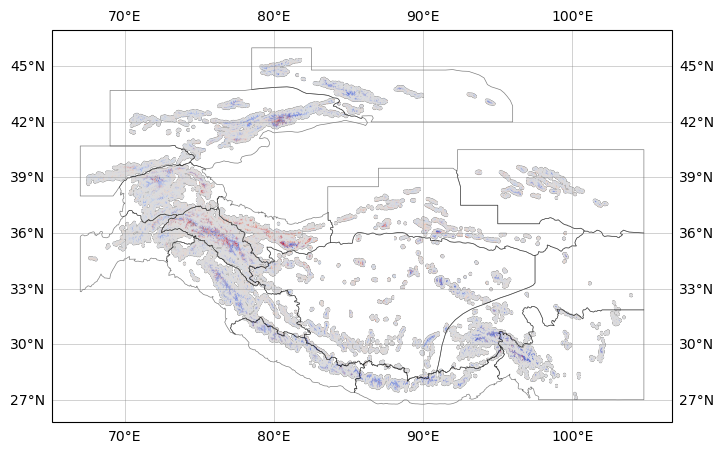

In [17]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.imshow(arr_down, cmap='coolwarm', vmin=-0.5, vmax=0.5, extent=dhdt_extent)
hma_gtng_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)


Text(0.5, 1.0, 'Glacier-specific dh/dt (2000-2019) [m/yr]')

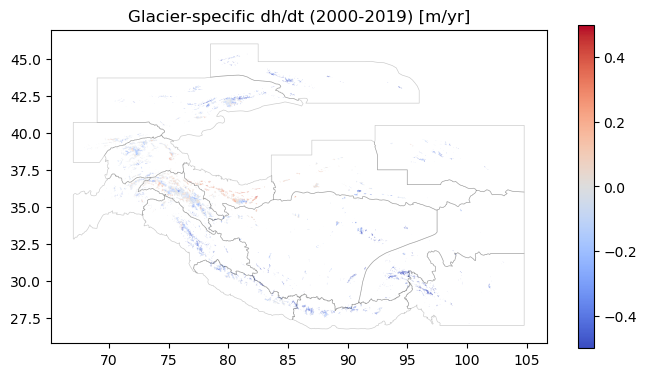

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
gla_dhdt_stats_gdf.plot(
    ax=ax,
    column='median',
    cmap='coolwarm',
    vmin=-0.5,
    vmax=0.5,
    legend=True,
    legend_kwds={'shrink': 0.7},
    )
hma_gtng_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.2)
ax.set_title('Glacier-specific dh/dt (2000-2019) [m/yr]')


In [3]:
### get the paths of the images covering the given geometry
def path_covers_geo(path, geo_shapely):
    filename = path.split('/')[-1]
    lat_min, lon_min = int(filename[1:3]), int(filename[4:7])
    if filename[0] == 'S': lat_min = -lat_min
    if filename[3] == 'W': lon_min = -lon_min
    map_bounds = box(lon_min, lat_min, lon_min+1, lat_min+1)
    geo_bounds = box(*geo_shapely.bounds)
    return map_bounds.intersects(geo_bounds)


In [11]:
path_hma_gtng = 'data/hma-extent/HMA/gtng_202307_hma_subregions.gpkg'
path_dhdt_gla_larger1 = 'data/glacier-extent/rgi70/hma_rgi70_larger1km2.gpkg'
dif_dhdt_map = 'data/glacier-height/gla-elev-change-hugonnet/gla-change_map_2000_2019/dhdt'
paths_dhdt_map = glob(dif_dhdt_map+'/*.tif')
print('Number of elevation change maps:',len(paths_dhdt_map))


Number of elevation change maps: 320


In [12]:
### read in data   
hma_gtng = gpd.read_file(path_hma_gtng)
hma_gtng = gpd.read_file(path_hma_gtng).to_crs(ccrs.PlateCarree().proj4_init)
dhdt_gla_larger1 = gpd.read_file(path_dhdt_gla_larger1)
# hma_gtng.head()
dhdt_gla_larger1.head(2)


rgi_id o1region o2region        glims_id  anlys_id  \
0  RGI2000-v7.0-G-13-00248       13    13-01  G068125E39075N    804889   
1  RGI2000-v7.0-G-13-00333       13    13-01  G068282E39191N    805121   

   subm_id             src_date     cenlon     cenlat  utm_zone  ...  \
0      752  2002-07-10T00:00:00  68.126015  39.073924        42  ...   
1      752  2002-07-10T00:00:00  68.281068  39.192206        42  ...   

      zmin_m     zmax_m     zmed_m    zmean_m  slope_deg  aspect_deg  \
0  3396.5350  4826.1430  4072.9604  4051.1255  21.975628  328.901207   
1  3771.6304  4999.9077  4048.8445  4157.0884  21.639221  350.579267   

   aspect_sec  dem_source  lmax_m  \
0           8    COPDEM30    3833   
1           1    COPDEM30    3330   

                                            geometry  
0  MULTIPOLYGON Z (((68.11814 39.07499 0, 68.1177...  
1  MULTIPOLYGON Z (((68.28872 39.1812 0, 68.28813...  

[2 rows x 29 columns]

In [19]:
# dhdt_gla_ours.head()
dhdt_gla_larger1.head(2)
dhdt_gla_larger1.columns

Index(['rgi_id', 'o1region', 'o2region', 'glims_id', 'anlys_id', 'subm_id',
       'src_date', 'cenlon', 'cenlat', 'utm_zone', 'area_km2', 'primeclass',
       'conn_lvl', 'surge_type', 'term_type', 'glac_name', 'is_rgi6',
       'termlon', 'termlat', 'zmin_m', 'zmax_m', 'zmed_m', 'zmean_m',
       'slope_deg', 'aspect_deg', 'aspect_sec', 'dem_source', 'lmax_m',
       'geometry'],
      dtype='object')

KeyError: 'dhdt'

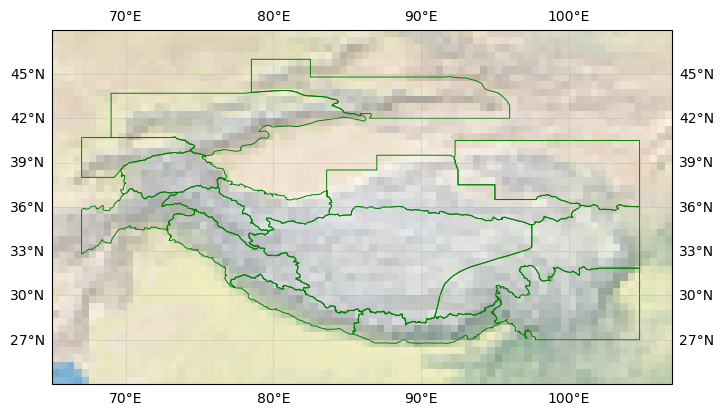

In [18]:
gla_area_clip = dhdt_gla_larger1['area_km2'].values/1_000_000
gla_area_clip[gla_area_clip>10] = 10   
gla_sel_centers = dhdt_gla_larger1.geometry.representative_point()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([65.0, 107.0, 24.0, 46.0])
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
ax.stock_img()
hma_gtng.plot(ax = ax, facecolor='None', edgecolor='green', lw=0.7)
scatter_plot(gla_sel_centers.x, gla_sel_centers.y, size=gla_area_clip,  
                          color=dhdt_gla_larger1['dhdt'].values, ax=ax, 
                          labels_size = [3, 6, 9], labels_color = [0.1, 0.4, 0.7], 
                          scale_size = 2, cmap="RdYlBu")
ax.set_title('HMA glacier elevation change for glaicers with area larger than 2 km2 (2000-2019)')


### Show glaciers with dh/dt larger than 0.5.

In [7]:
### select glaciers with dh/dt larger than 0.
dhdt_gla_larger1_lower05 = dhdt_gla_larger1[dhdt_gla_larger1['dhdt'] < -0.5]
dhdt_gla_larger1_lower05 = dhdt_gla_larger1_lower05.reset_index()
print(dhdt_gla_larger1.shape)
print(dhdt_gla_larger1_lower05.shape)


(10689, 12)
(2671, 13)


Text(0.5, 1.0, 'HMA glacier elevation change for glaicers with area larger than 2 km2 (2000-2019)')

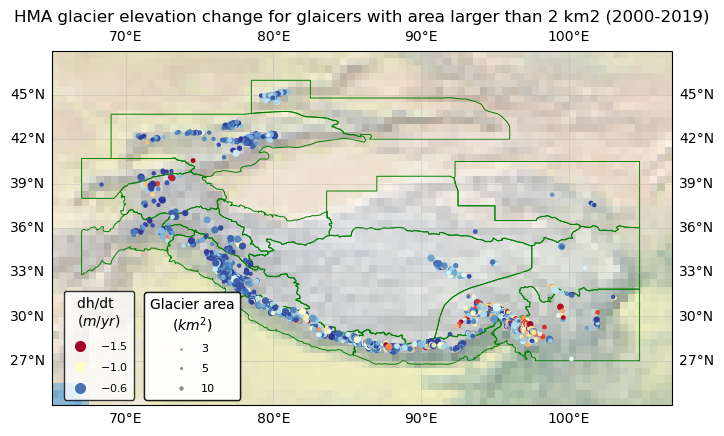

In [8]:
gla_area_clip_ = dhdt_gla_larger1_lower05['area'].values/1_000_000
gla_area_clip_[gla_area_clip_>10] = 10                                 
gla_larger0_higher0_centers = dhdt_gla_larger1_lower05.geometry.representative_point()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([65.0, 107.0, 24.0, 46.0])
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
ax.stock_img()
hma_gtng.plot(ax = ax, facecolor='None', edgecolor='green', lw=0.7)
ax = scatter_plot(gla_larger0_higher0_centers.x, gla_larger0_higher0_centers.y, size=gla_area_clip_,  
                          color=dhdt_gla_larger1_lower05['dhdt'].values, ax=ax, 
                          labels_size = [3, 5, 10], labels_color = [-1.5, -1, -0.6], 
                          scale_size = 1, color_range=[-1.5, -0.5], cmap="RdYlBu")
ax.set_title('HMA glacier elevation change for glaicers with area larger than 2 km2 (2000-2019)')



### Show glaciers with dh/dt larger than 0.


In [9]:
### select glaciers with dh/dt larger than 0.
dhdt_gla_larger1_higher0 = dhdt_gla_larger1[dhdt_gla_larger1['dhdt'] > 0]
dhdt_gla_larger1_higher0 = dhdt_gla_larger1_higher0.reset_index()
print(dhdt_gla_larger1.shape)
print(dhdt_gla_larger1_higher0.shape)


(10689, 12)
(1943, 13)


Text(0.5, 1.0, 'HMA glacier elevation change for glaicers with area larger than 2 km2 (2000-2019)')

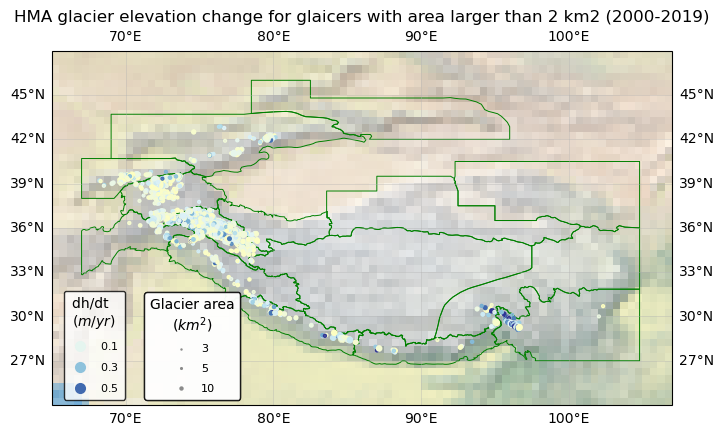

In [10]:
gla_area_clip_ = dhdt_gla_larger1_higher0['area'].values/1_000_000
gla_area_clip_[gla_area_clip_>10] = 10    
gla_larger1_higher0_centers = dhdt_gla_larger1_higher0.geometry.representative_point()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([65.0, 107.0, 24.0, 46.0])
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
ax.stock_img()
hma_gtng.plot(ax = ax, facecolor='None', edgecolor='green', lw=0.7)
ax = scatter_plot(gla_larger1_higher0_centers.x, gla_larger1_higher0_centers.y, size=gla_area_clip_,  
                          color=dhdt_gla_larger1_higher0['dhdt'].values, ax=ax, 
                          labels_size = [3, 5, 10], labels_color = [0.1, 0.3, 0.5], 
                          scale_size = 1, color_range=[-0.6,0.6], cmap="RdYlBu")
ax.set_title('HMA glacier elevation change for glaicers with area larger than 2 km2 (2000-2019)')


### Show glaciers with dh/dt larger than 0.5.

In [11]:
### select glaciers with dh/dt larger than 0.5.
dhdt_gla_larger1_higher05 = dhdt_gla_larger1[dhdt_gla_larger1['dhdt'] > 0.5]
dhdt_gla_larger1_higher05 = dhdt_gla_larger1_higher05.reset_index()
print(dhdt_gla_larger1.shape)
print(dhdt_gla_larger1_higher05.shape)


(10689, 12)
(44, 13)


Text(0.5, 1.0, 'HMA glacier elevation change for glaicers with area larger than 2 km2 (2000-2019)')

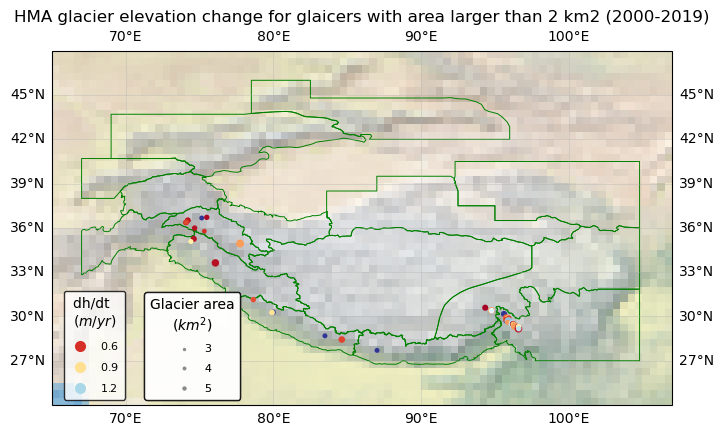

In [12]:
gla_area_clip_ = dhdt_gla_larger1_higher05['area'].values/1_000_000
gla_area_clip_[gla_area_clip_>10] = 10   
gla_larger0_higher05_centers = dhdt_gla_larger1_higher05.geometry.representative_point()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([65.0, 107.0, 24.0, 46.0])
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
ax.stock_img()
hma_gtng.plot(ax = ax, facecolor='None', edgecolor='green', lw=0.7)
ax = scatter_plot(gla_larger0_higher05_centers.x, gla_larger0_higher05_centers.y, size=gla_area_clip_,  
                          color=dhdt_gla_larger1_higher05['dhdt'].values, ax=ax, 
                          labels_size = [3, 4, 5], labels_color = [0.6, 0.9, 1.2], 
                          scale_size = 2, color_range=[0.5, 1.5], cmap="RdYlBu")
ax.set_title('HMA glacier elevation change for glaicers with area larger than 2 km2 (2000-2019)')


#### Check the elevation change map

In [ ]:
id = 42
geo = dhdt_gla_larger1_higher05.loc[id, 'geometry']
dhdt = dhdt_gla_larger1_higher05.loc[id, 'dhdt']
rgi_id = dhdt_gla_larger1_higher05.loc[id, 'rgiid']
area = dhdt_gla_larger1_higher05.loc[id, 'area']/1_000_000
print(rgi_id, dhdt, area)

RGI60-15.12550 0.9608 2.171


dhdt by map:0.6507965922355652


<Axes: >

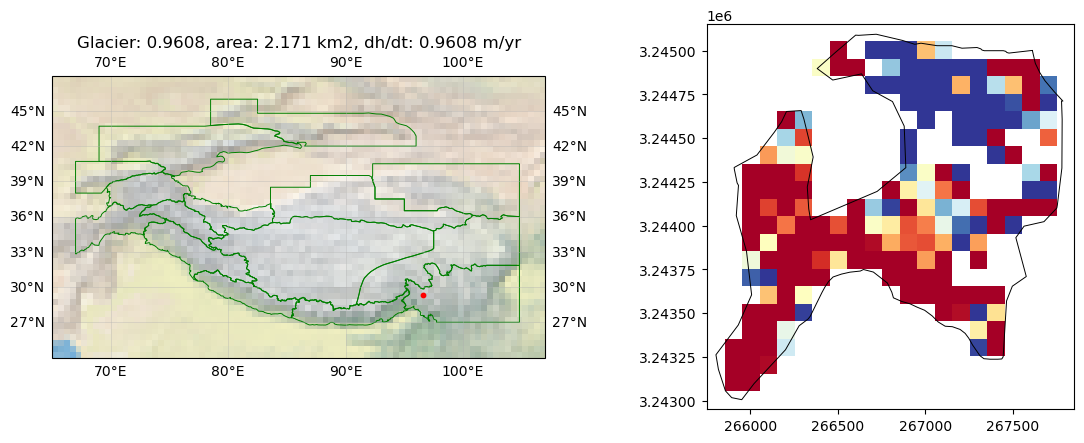

In [18]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax.set_extent([65.0, 107.0, 24.0, 46.0])
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
ax.stock_img()
hma_gtng.plot(ax = ax, facecolor='None', edgecolor='green', lw=0.7)
ax.scatter(x=geo.centroid.x, y=geo.centroid.y, s=10, c='red', zorder=2)
ax.set_title(f'Glacier: {dhdt}, area: {area} km2, dh/dt: {dhdt} m/yr')

cover_imgs = [path for path in paths_dhdt_map if path_covers_geo(path, geo_shapely=geo)]
## plot the elevation change map
if len(cover_imgs) == 1:
  with rasterio.open(cover_imgs[0]) as src:
    geo_utm = gpd.GeoDataFrame(geometry=[geo], crs=dhdt_gla_larger1_higher0.crs)\
                                          .to_crs(epsg=src.crs.to_epsg())
    out_image, out_transform = mask(src, [geo_utm.geometry[0]], crop=True)
    out_image[out_image==src.nodata] = np.nan
print(f'dhdt by map:{np.nanmean(out_image[0])}')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(out_image[0], cmap='RdYlBu', vmin=-0.6, vmax=0.6, 
                    extent=[out_transform[2], out_transform[2]+out_transform[0]*out_image.shape[2], 
                            out_transform[5]+out_transform[4]*out_image.shape[1], out_transform[5]]) 
geo_utm.plot(ax=ax2, facecolor='None', edgecolor='black', lw=0.7)


3.4893732970027247